# Visualization of SLDSC results
This notebook contains scripts to visualize SLDSC results from trait-specific and meta-analyses.

## 01 Load library

In [1]:
.libPaths(c("/projectnb/tcwlab/LabMember/pwang1/.conda/envs/r_env/lib/R/library", "/share/pkg.8/r/4.4.0/install/lib64/R/library" ))
library(tidyverse)
library(ggplot2)
library(stringr)
library(data.table)
library(ggpubr)
library(RColorBrewer)
library(colorspace) 
library(data.table)
library(ComplexHeatmap)
library(circlize)
library(grid)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: grid

ComplexHeatmap version 2.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page:

## 02 Prepare the data

In [2]:
loci.dir <- "/projectnb/tcwlab/LabMember/pwang1/projects/Enrichment_EOO_GaoW/sLDSC/ADSP_1000G_analysis/input/files_for_pipline/"
out.dir <- "/projectnb/tcwlab/LabMember/pwang1/projects/Enrichment_EOO_GaoW/sLDSC/ADSP_1000G_analysis/output/"

## loci info (univariate, multicontext, multigene and fsusie)
loci.uni <- fread(paste0(loci.dir, "loci_info.txt"))
loci.multi <- fread(paste0(loci.dir, "loci_multigene_all.txt"))
loci.susie <- fread(paste0(loci.dir, "loci_susie_fsusie.txt"))

loci.all <- rbind(loci.uni, loci.multi, loci.susie)
loci.info <- loci.all[loci.all$method != "trans",]
loci.info <- loci.info[!duplicated(loci.info$study),]
studies <- loci.info$study

## import sumstats file info from TASKFILES
brain.trait <- fread("/projectnb/tcwlab/LabMember/pwang1/projects/Enrichment_EOO_GaoW/sLDSC/ADSP_1000G_analysis/TASKFILES_polyfun/sumstats_colocboost_brain.txt",header = F)
blood.trait <- fread("/projectnb/tcwlab/LabMember/pwang1/projects/Enrichment_EOO_GaoW/sLDSC/ADSP_1000G_analysis/TASKFILES_polyfun/sumstats_colocboost_blood.txt",header = F)
all.trait <- fread("/projectnb/tcwlab/LabMember/pwang1/projects/Enrichment_EOO_GaoW/sLDSC/ADSP_1000G_analysis/TASKFILES_polyfun/sumstats_colocboost_all.txt",header = F)

res.dir <- "/projectnb/tcwlab/LabMember/pwang1/projects/Enrichment_EOO_GaoW/sLDSC/ADSP_1000G_analysis/output/"



Warning message in fread(paste0(loci.dir, "loci_info.txt")):
“Detected 4 column names but the data has 5 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread(paste0(loci.dir, "loci_multigene_all.txt")):
“Detected 4 column names but the data has 5 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread(paste0(loci.dir, "loci_susie_fsusie.txt")):
“Detected 4 column names but the data has 5 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames

## 03 Traits specific analysis

In [3]:
## Import SLDSC results on traits specific levels
enrich.list <- list()
for (study in studies) {
  se1 <- readRDS(paste0(res.dir, study, "/sumstats/",study, ".single_tau.initial_processed_stats.rds"))
  enrich <- bind_rows(
  lapply(names(se1), function(nm) {
    tmp <- se1[[nm]][["enrichment"]][["enrichment_summary"]]
    tmp$dataset <- nm 
    tmp
    })
  )
  enrich$study <- study
  enrich$trait <- gsub(".sumstats.parquet","",enrich$dataset)
  enrich.list[[study]] <- enrich
}

## Reshape the results
enrich.df <- do.call(rbind,enrich.list)
colnames(enrich.df)[1:4] <- c("Enrichment","Enrichment_std_error","Prop._h2","Prop._SNPs")
enrich.df$trait_group <- NA
enrich.df$trait_group[enrich.df$dataset %in% blood.trait$V1] <- "Blood"
enrich.df$trait_group[enrich.df$dataset %in% brain.trait$V1] <- "Brain"
enr.df <- enrich.df[!is.na(enrich.df$trait_group),]
enr.df$trait <- gsub("_munged.parquet","",enr.df$trait)

str(enr.df)


Classes ‘data.table’ and 'data.frame':	5840 obs. of  9 variables:
 $ Enrichment          : num  -30.12 11.53 -59.09 -2.28 8.51 ...
 $ Enrichment_std_error: num  61.1 31.8 43.7 19.4 29.4 ...
 $ Prop._h2            : num  -0.01467 0.00562 -0.02879 -0.00111 0.00415 ...
 $ Prop._SNPs          : num  0.000487 0.000487 0.000487 0.000487 0.000487 ...
 $ Enrichment_p        : num  0.606 0.741 0.16 0.865 0.799 ...
 $ dataset             : chr  "EXF.sumstats.parquet" "LAN.sumstats.parquet" "MEM.sumstats.parquet" "MS.sumstats.parquet" ...
 $ study               : chr  "AC_DeJager_eQTL" "AC_DeJager_eQTL" "AC_DeJager_eQTL" "AC_DeJager_eQTL" ...
 $ trait               : chr  "EXF" "LAN" "MEM" "MS" ...
 $ trait_group         : chr  "Brain" "Brain" "Brain" "Brain" ...
 - attr(*, ".internal.selfref")=<externalptr> 


### Heatmap showing Enrichment values across QTL studies 

In [4]:
enr_unique <- as.data.table(enr.df)

## Matrix for Enrichment values and corresponding p values
mat_enr <- dcast(enr_unique, study ~ trait, value.var = "Enrichment")
mat_p   <- dcast(enr_unique, study ~ trait, value.var = "Enrichment_p")

m_enr <- as.matrix(mat_enr[, -1])
rownames(m_enr) <- mat_enr$study

m_p <- as.matrix(mat_p[, -1])
rownames(m_p) <- mat_p$study

## Set colors for heatmap
lim <- max(abs(m_enr), na.rm = TRUE)
col_fun <- colorRamp2(
  c(-1000, -500, -100, 0, 100, 500, 1000),
  c("navy", "blue", "lightblue", "white", "pink", "red", "darkred")
)
## Set loci type
loci.df <- loci.info[match(rownames(m_enr), loci.info$study),]
loci.df$loci_type <- "other"
loci.df$loci_type[grepl("_eQTL", loci.df$study)] <- "eQTL"
loci.df$loci_type[grepl("_sQTL", loci.df$study)] <- "sQTL"
loci.df$loci_type[grepl("_pQTL", loci.df$study)] <- "pQTL"
loci.df$loci_type[grepl("_gpQTL", loci.df$study)] <- "gpQTL"
loci.df$loci_type[grepl("_haQTL", loci.df$study)] <- "haQTL"
loci.df$loci_type[grepl("_mQTL", loci.df$study)] <- "mQTL"
loci.df$loci_group <- paste0(loci.df$method, "_", loci.df$loci_type)
loci.group <- loci.df$loci_group
names(loci.group) <- loci.df$study

## Classify traits
tra.df <- enr.df[!duplicated(enr.df$trait),]
tra.df <- tra.df[match(colnames(m_enr), tra.df$trait),]
tra.group <- tra.df$trait_group
names(tra.group) <- tra.df$trait

tra.df <- tra.df %>%
  mutate(category = case_when(
    # Neuroimaging traits
    grepl("^(accumbens|amygdala|brainstem|caudate|pallidum|putamen)$", trait, ignore.case = TRUE) |
      grepl("(\\.surf$|\\.thick$)", trait, ignore.case = TRUE) |
      grepl("^image_", trait, ignore.case = TRUE) ~ "Neuroimaging",

    # AD
    grepl("^AD_", trait, ignore.case = TRUE) | grepl("Alzheimer", trait, ignore.case = TRUE) ~ "AD",

    # Neurodegenerative（only ALS/PD）
    grepl("^ALS", trait, ignore.case = TRUE) | grepl("nallsEtAl", trait, ignore.case = TRUE) ~ "Neurodegenerative",

    # Psychiatric
    grepl("Schizophrenia|SCZ|Bipolar|MDD|Depression|Anorexia|Autism|ADHD|Neuroticism", trait, ignore.case = TRUE) |
      grepl("^PGC", trait, ignore.case = TRUE) ~ "Psychiatric",

    # Autoimmune 
    grepl("Multiple_sclerosis|IBD|_UC_|_CD_|\\bUC_|Celiac|Lupus|Rheumatoid_Arthritis|Primary_biliary_cirrhosis|Type_1_Diabetes|Hypothyroidism|AID_Combined|ALLERGY|ECZEMA",
          trait, ignore.case = TRUE) ~ "Autoimmune",

    # Blood（blood cell）
    grepl("^UKB\\.(Baso|Eosino|Lym|Mono|Neutro|Plt|RBC|MCV)\\.BOLT$", trait) |
      grepl("^UKB_460K\\.blood_RBC_DISTRIB_WIDTH$", trait) ~ "Blood",

    # Behavioral (behavioral/lifestyle/cognition)
    grepl("BMI|Smoking|Morning_Person|Insomnia|Sleep(Duration)?|AgeFirstBirth|NumberChildrenEverBorn|Intelligence|EDU|Education|ReactionTime",
          trait, ignore.case = TRUE) |
      trait %in% c("EXF","LAN","MEM") |
      grepl("^MS$", trait) ~ "Behavioral",

    TRUE ~ "Other"
  ))

group_short <- tra.df$category
names(group_short) <- tra.df$trait

# Set colors for loci studies
grp_lv  <- unique(loci.group)
set.seed(1)
#grp_col <- setNames(randomcoloR::distinctColorPalette(length(grp_lv)), grp_lv)
distinct_palette <- function(n, palette = "Dark 3") {
  colorspace::qualitative_hcl(n, palette = palette)
}
grp_col <- setNames(distinct_palette(length(grp_lv), palette = "Dark 3"), grp_lv)

ha_left <- rowAnnotation(
  Group = loci.group,
  col = list(Group = grp_col),
  width = unit(5, "mm"),
  annotation_name_side = "top"
)

## Drawing heatmap
ht <- Heatmap(
  m_enr,
  name = "Enrichment",
  col = col_fun,
  na_col = "grey90",
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  row_split = loci.group,
  column_split = group_short,
  left_annotation = ha_left,
  show_row_names = T,
  row_title = NULL,
  row_gap = unit(1, "mm"),
  rect_gp = gpar(col = NA),
  column_names_max_height = unit(12, "cm"),
  cell_fun = function(j, i, x, y, width, height, fill) {
    if (!is.na(m_p[i, j]) && m_p[i, j] < 0.05 & m_p[i, j] > 0.01){
      if(abs(m_enr[i,j]) > 500) grid.text("*",   x, y, gp = gpar(fontsize = 13, fontface = "bold",col="white"))
      if(abs(m_enr[i,j]) <= 500) grid.text("*",   x, y, gp = gpar(fontsize = 13, fontface = "bold",col="black"))
    }  
    if (!is.na(m_p[i, j]) && m_p[i, j] < 0.01 & m_p[i, j] > 0.001){
      if(abs(m_enr[i,j]) > 500) grid.text("**",  x, y, gp = gpar(fontsize = 12, fontface = "bold",col="white"))
      if(abs(m_enr[i,j]) <= 500) grid.text("**",  x, y, gp = gpar(fontsize = 12, fontface = "bold",col="black"))
    } 
    if (!is.na(m_p[i, j]) && m_p[i, j] < 0.001){
      if(abs(m_enr[i,j]) > 500) grid.text("***", x, y, gp = gpar(fontsize = 11, fontface = "bold",col="white"))
      if(abs(m_enr[i,j]) <= 500) grid.text("***", x, y, gp = gpar(fontsize = 11, fontface = "bold",col="black"))
    }                     
  }
)


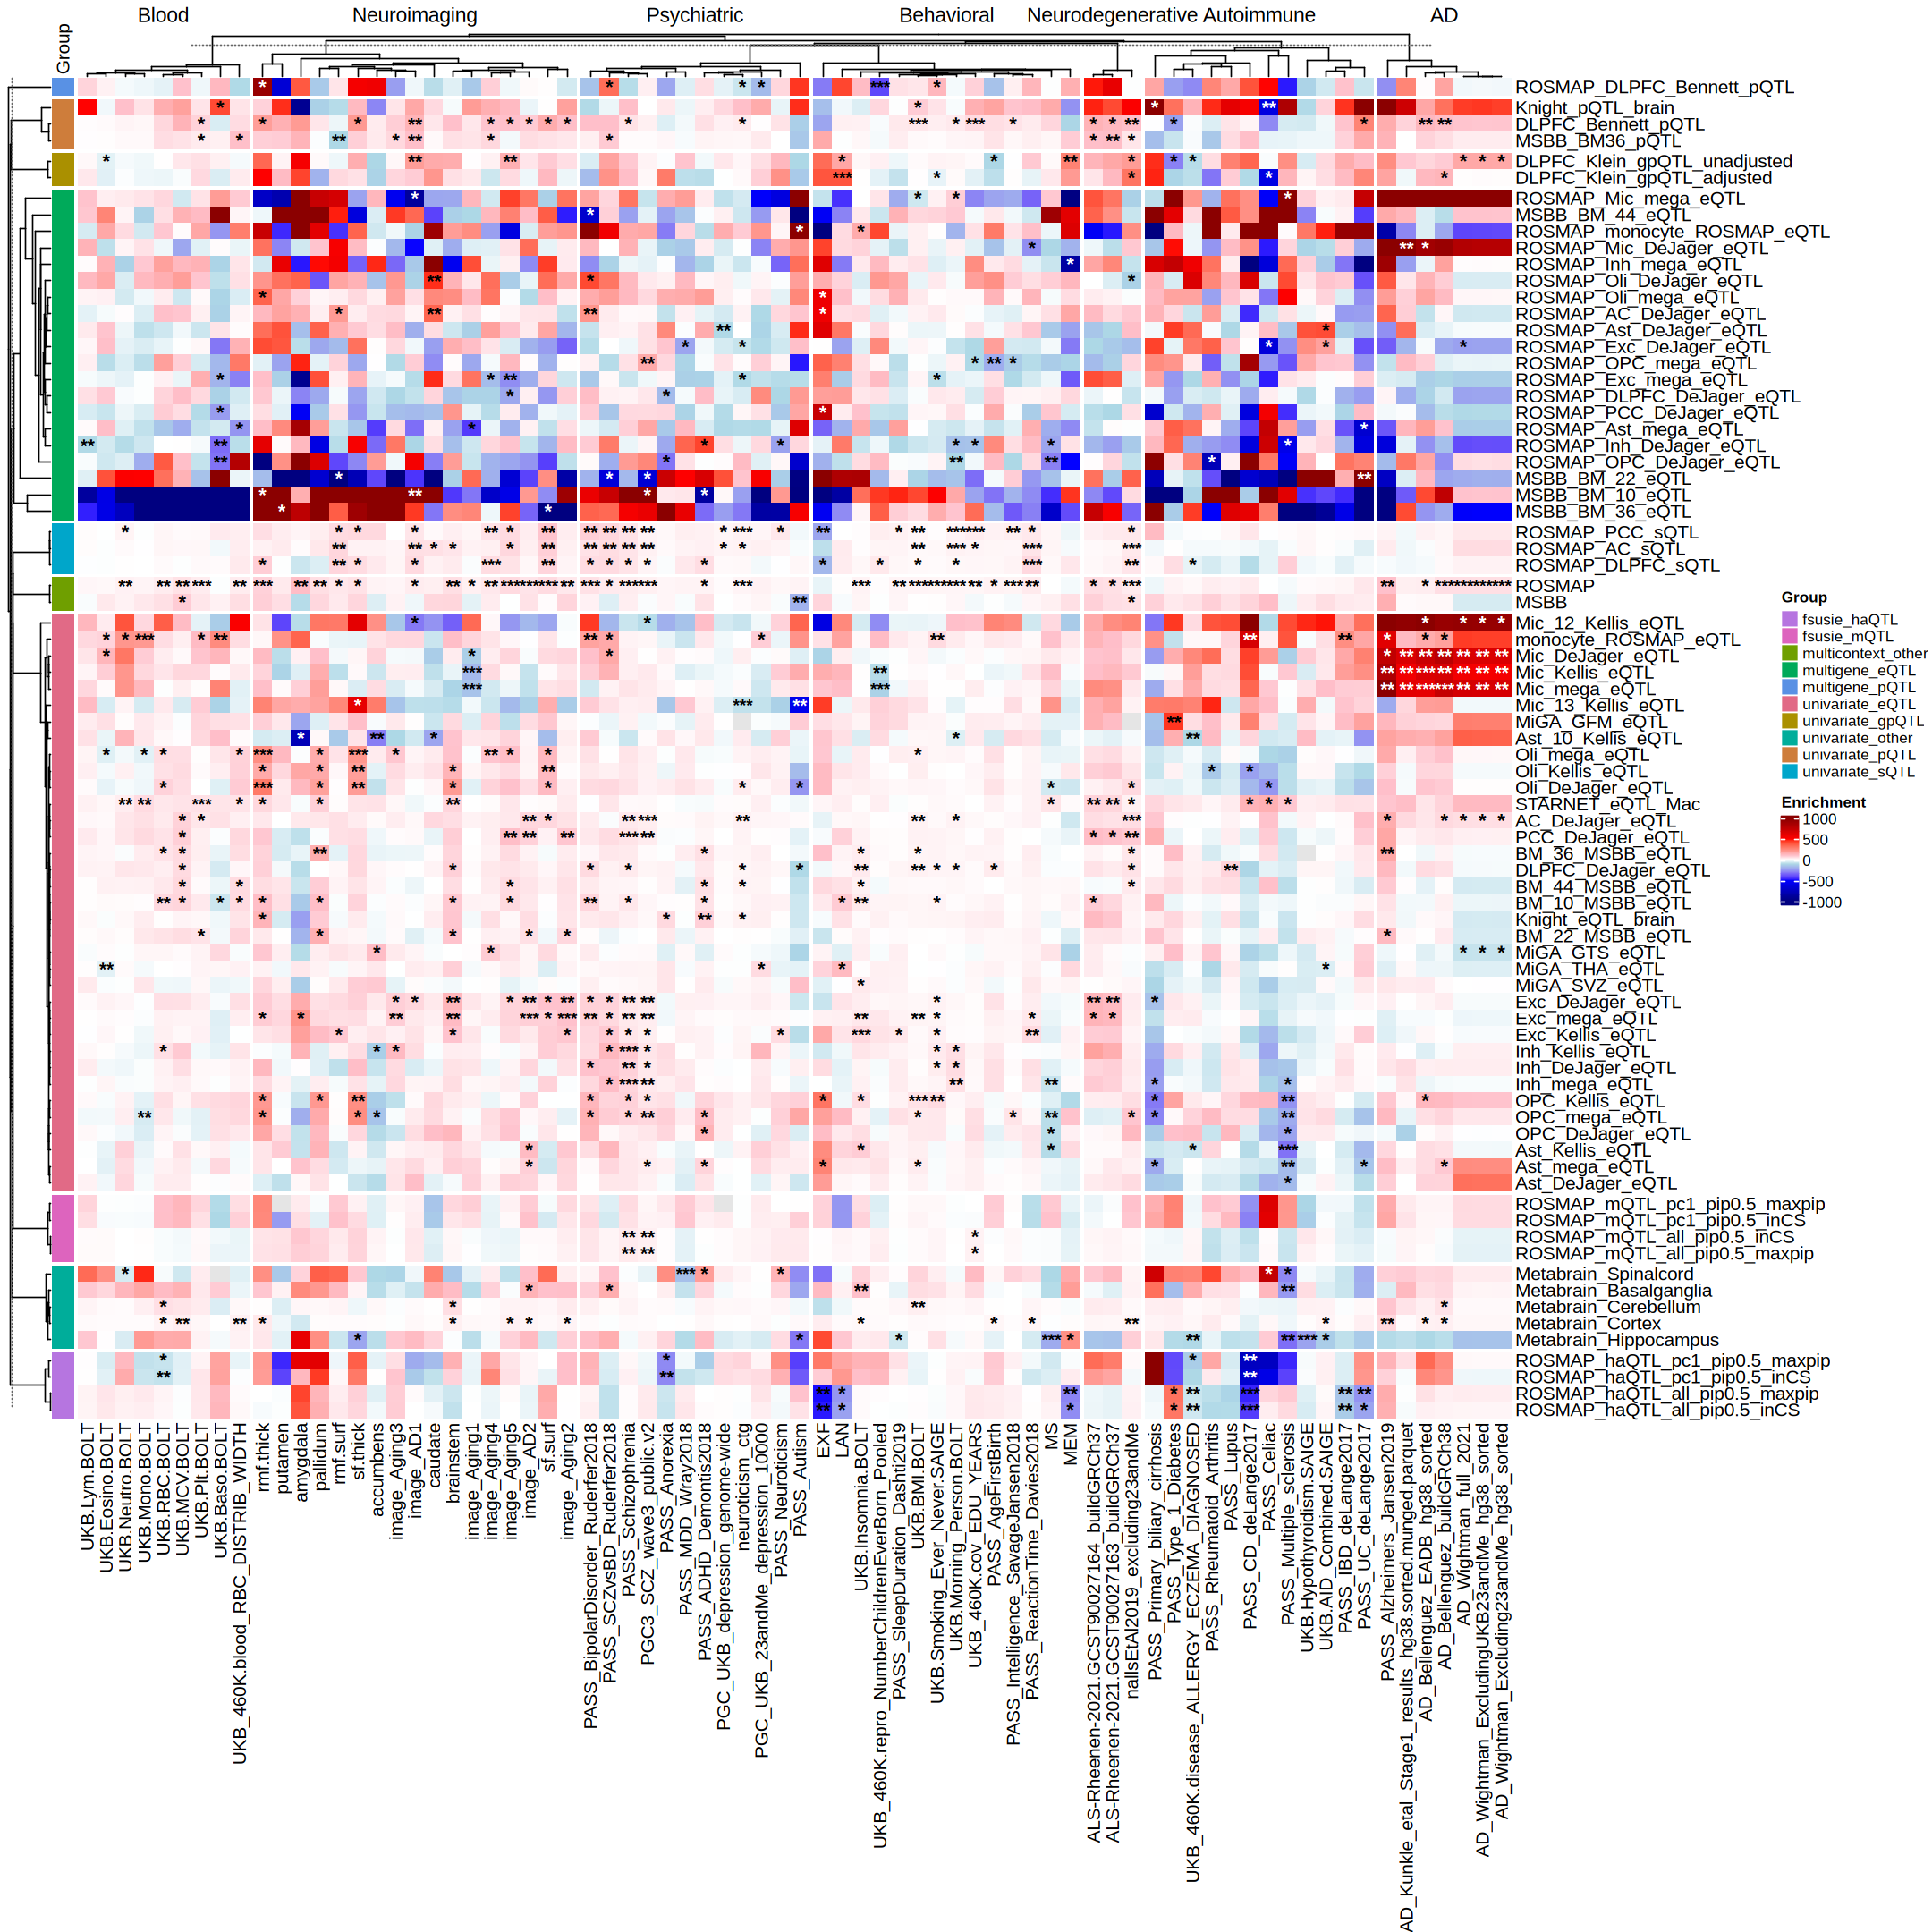

In [5]:
## Show results
options(repr.plot.width = 18, repr.plot.height = 18)
draw(ht, heatmap_legend_side = "right", annotation_legend_side = "right")

In [6]:
## Save figure
pdf("Enrichment_all.pdf",width = 22,height = 17)
draw(ht, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

pdf 
  2

### AD traits

In [7]:
## Subset AD traits
enr.sig <- enr.df[enr.df$Enrichment_p < 0.05,]
enr.sel <- enr.sig[enr.sig$trait %in% tra.df$trait[tra.df$category== "AD"],]
enr <- as.data.table(enr.df[enr.df$study %in% unique(enr.sel$study),])
enr_unique <- enr

## Matrix for Enrichment values and corresponding p values
mat_enr <- dcast(enr_unique, study ~ trait, value.var = "Enrichment")
mat_p   <- dcast(enr_unique, study ~ trait, value.var = "Enrichment_p")
m_enr <- as.matrix(mat_enr[, -1])
rownames(m_enr) <- mat_enr$study
m_p <- as.matrix(mat_p[, -1])
rownames(m_p) <- mat_p$study

## Set colors
lim <- max(abs(m_enr), na.rm = TRUE)
#col_fun <- colorRamp2(c(-lim, 0, lim), c("#2166AC", "white", "#B2182B"))
col_fun <- colorRamp2(
  c(-1000, -500, -100, 0, 100, 500, 1000),
  c("navy", "blue", "lightblue", "white", "pink", "red", "darkred")
)
loci.sub <- loci.df[match(rownames(m_enr),loci.df$study),]
  rownames(m_enr)
tra.group <- tra.df[match(colnames(m_enr), tra.df$trait),]

ht <- Heatmap(
  m_enr,
  name = "Enrichment",
  col = col_fun,
  na_col = "grey90",
  cluster_rows = TRUE,
  cluster_columns = TRUE,row_split = loci.sub$loci_group,column_split = tra.group$category,
  column_names_max_height = unit(12, "cm"),
  rect_gp = gpar(col = NA), 
  cell_fun = function(j, i, x, y, width, height, fill) {
    if (!is.na(m_p[i, j]) && m_p[i, j] < 0.05 & m_p[i, j] > 0.01){
      if(abs(m_enr[i,j]) > 500) grid.text("*",   x, y, gp = gpar(fontsize = 13, fontface = "bold",col="white"))
      if(abs(m_enr[i,j]) <= 500) grid.text("*",   x, y, gp = gpar(fontsize = 13, fontface = "bold",col="black"))
    }  
    if (!is.na(m_p[i, j]) && m_p[i, j] < 0.01 & m_p[i, j] > 0.001){
      if(abs(m_enr[i,j]) > 500) grid.text("**",  x, y, gp = gpar(fontsize = 12, fontface = "bold",col="white"))
      if(abs(m_enr[i,j]) <= 500) grid.text("**",  x, y, gp = gpar(fontsize = 12, fontface = "bold",col="black"))
    } 
    if (!is.na(m_p[i, j]) && m_p[i, j] < 0.001){
      if(abs(m_enr[i,j]) > 500) grid.text("***", x, y, gp = gpar(fontsize = 11, fontface = "bold",col="white"))
      if(abs(m_enr[i,j]) <= 500) grid.text("***", x, y, gp = gpar(fontsize = 11, fontface = "bold",col="black"))
    }                     
  }
)

grp_lv  <- unique(loci.sub$loci_group)
set.seed(1)
distinct_palette <- function(n, palette = "Dark 3") {
  colorspace::qualitative_hcl(n, palette = palette)
}
grp_col <- setNames(distinct_palette(length(grp_lv), palette = "Dark 3"), grp_lv)

ha_left <- rowAnnotation(
  Group = loci.sub$loci_group,  
  col = list(Group = grp_col),
  width = unit(5, "mm"),
  annotation_name_side = "top"
)


ht <- Heatmap(
  m_enr,
  name = "Enrichment",
  col = col_fun,
  na_col = "grey90",
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  row_split = loci.sub$loci_group,   
  column_split = tra.group$category,
  left_annotation = ha_left,
  show_row_names = T,
  row_title = NULL,
  row_gap = unit(1, "mm"),
  rect_gp = gpar(col = NA),
  column_names_max_height = unit(12, "cm"),
  cell_fun = function(j, i, x, y, width, height, fill) {
    if (!is.na(m_p[i, j]) && m_p[i, j] < 0.05 & m_p[i, j] > 0.01){
      if(abs(m_enr[i,j]) > 500) grid.text("*",   x, y, gp = gpar(fontsize = 13, fontface = "bold",col="white"))
      if(abs(m_enr[i,j]) <= 500) grid.text("*",   x, y, gp = gpar(fontsize = 13, fontface = "bold",col="black"))
    }  
    if (!is.na(m_p[i, j]) && m_p[i, j] < 0.01 & m_p[i, j] > 0.001){
      if(abs(m_enr[i,j]) > 500) grid.text("**",  x, y, gp = gpar(fontsize = 12, fontface = "bold",col="white"))
      if(abs(m_enr[i,j]) <= 500) grid.text("**",  x, y, gp = gpar(fontsize = 12, fontface = "bold",col="black"))
    } 
    if (!is.na(m_p[i, j]) && m_p[i, j] < 0.001){
      if(abs(m_enr[i,j]) > 500) grid.text("***", x, y, gp = gpar(fontsize = 11, fontface = "bold",col="white"))
      if(abs(m_enr[i,j]) <= 500) grid.text("***", x, y, gp = gpar(fontsize = 11, fontface = "bold",col="black"))
    }                     
  }
)
pdf("Enrichment_AD.pdf",width = 22,height = 9)
draw(ht)
dev.off()

[1] "AC_DeJager_eQTL"              "Ast_mega_eQTL"               
 [3] "BM_22_MSBB_eQTL"              "BM_36_MSBB_eQTL"             
 [5] "DLPFC_Bennett_pQTL"           "DLPFC_Klein_gpQTL_adjusted"  
 [7] "DLPFC_Klein_gpQTL_unadjusted" "Metabrain_Cerebellum"        
 [9] "Metabrain_Cortex"             "MiGA_GTS_eQTL"               
[11] "Mic_12_Kellis_eQTL"           "Mic_DeJager_eQTL"            
[13] "Mic_Kellis_eQTL"              "Mic_mega_eQTL"               
[15] "OPC_Kellis_eQTL"              "ROSMAP"                      
[17] "ROSMAP_Exc_DeJager_eQTL"      "ROSMAP_Mic_DeJager_eQTL"     
[19] "monocyte_ROSMAP_eQTL"

pdf 
  2

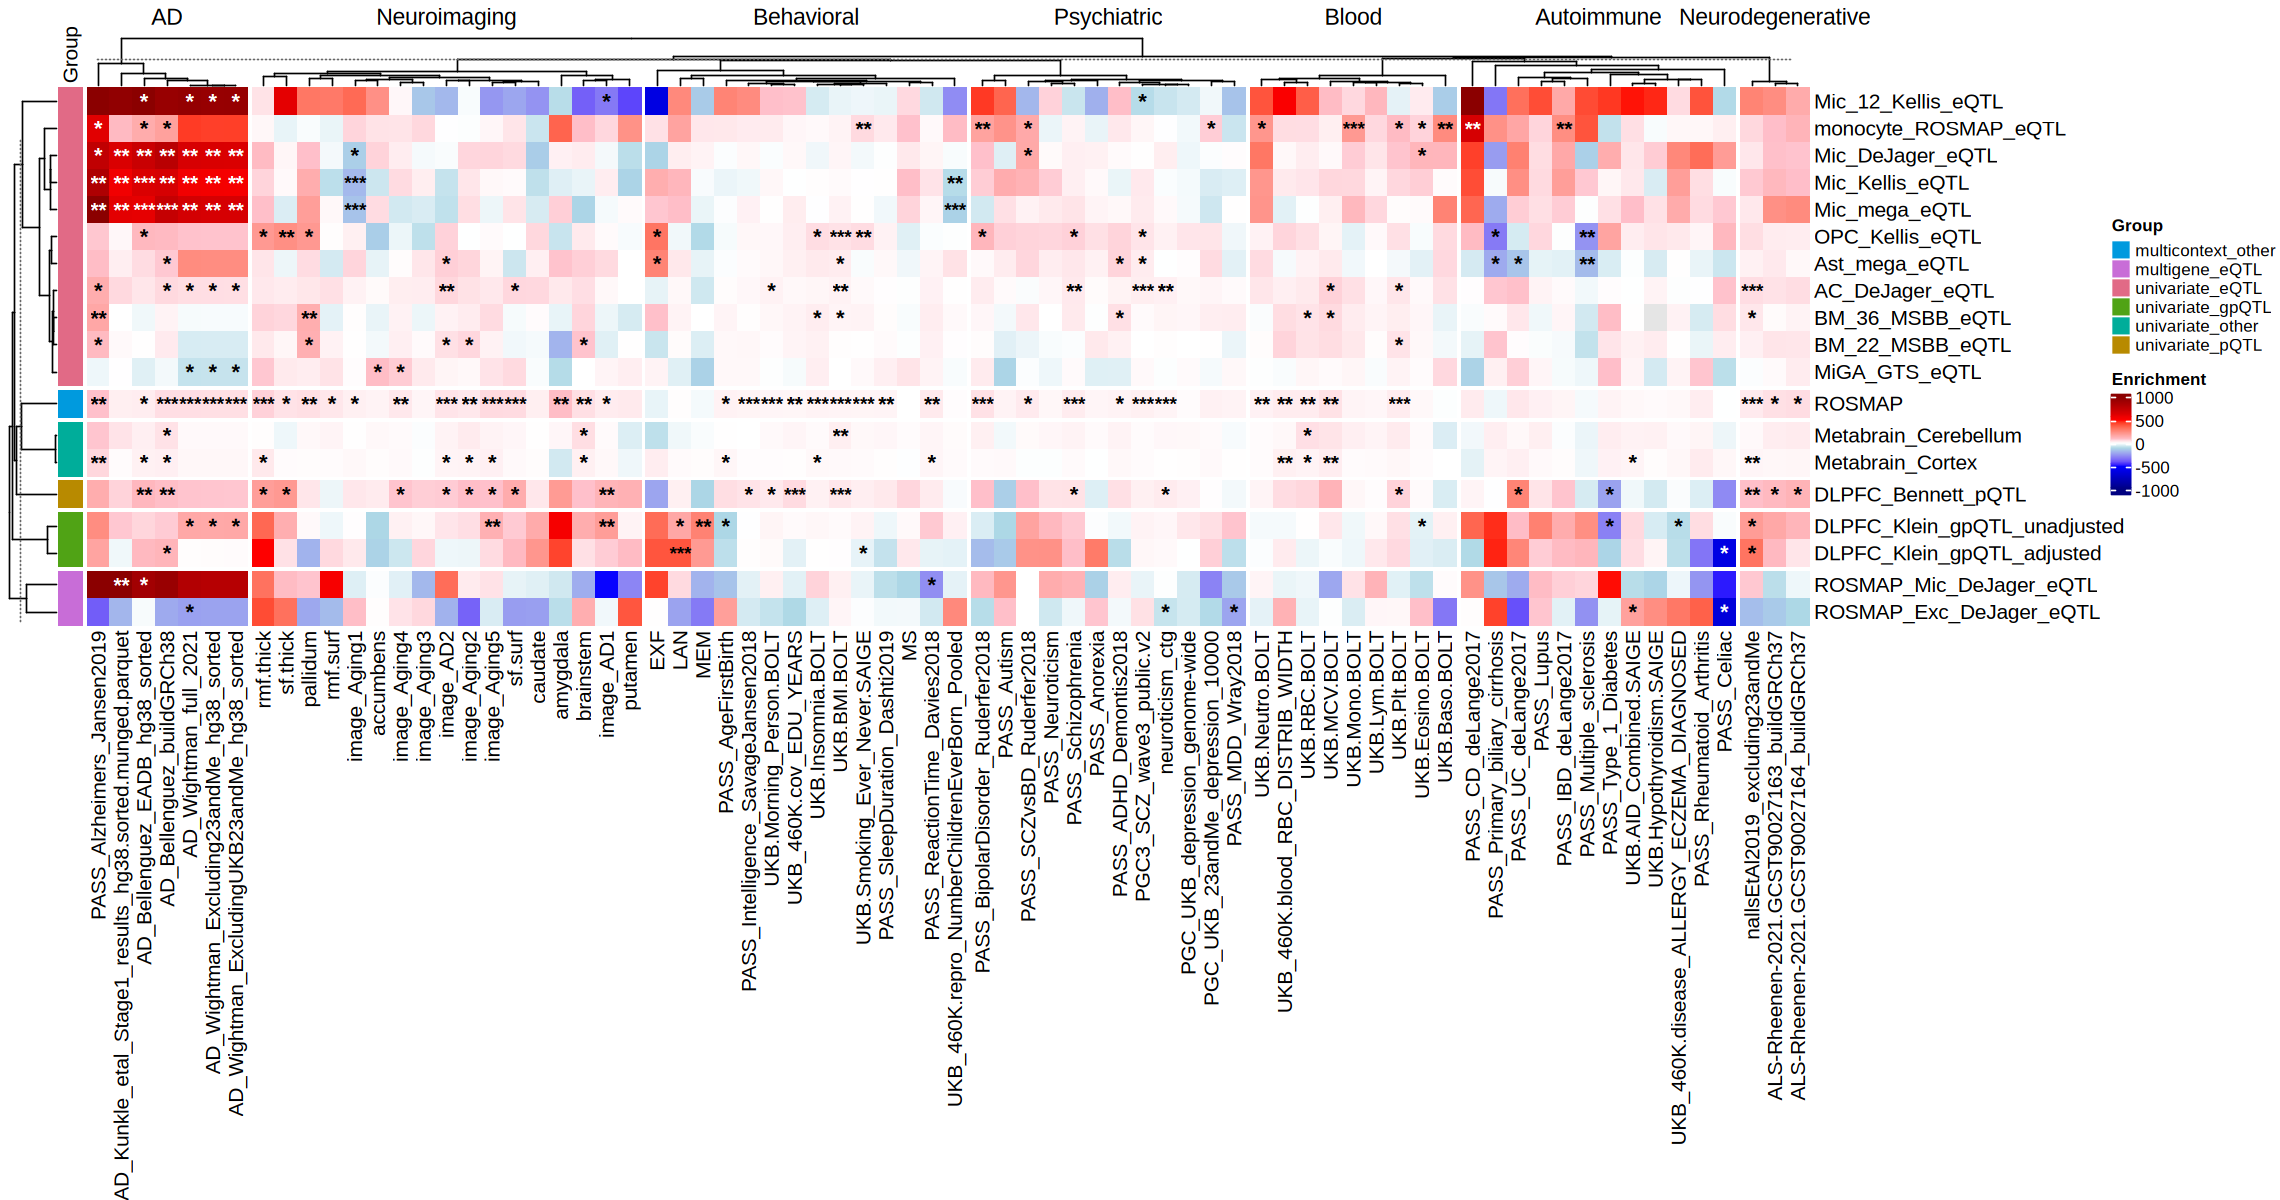

In [8]:
## Show results
options(repr.plot.width = 19, repr.plot.height = 10)
draw(ht, heatmap_legend_side = "right", annotation_legend_side = "right")

## 04 Meta analysis

### Barplot showing marginal tau values across QTL studies

[1] TRUE

[1] TRUE

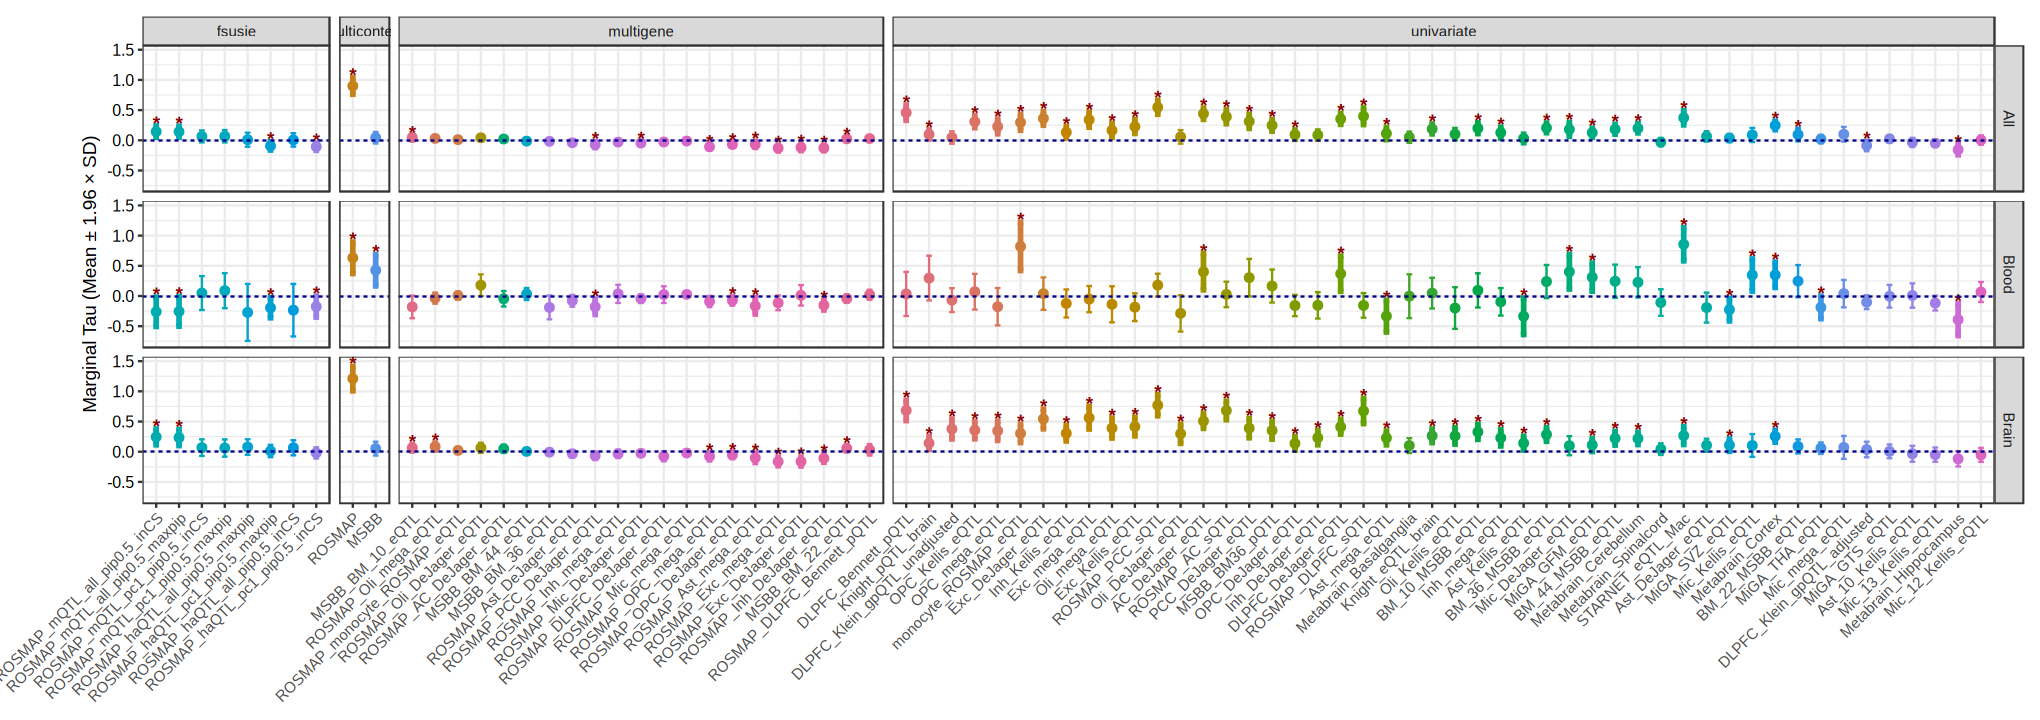

In [9]:
options(repr.plot.width = 17, repr.plot.height = 6)
## Data prepare
tau.list <- list()
enrich.list <- list()
for (study in studies) {
  meta.dir <- paste0(res.dir, study, "/sumstats/processed_stats_2/single_tau.",study, ".meta_processed_stats.rds")
  metas <- readRDS(meta.dir)
  tau.list[[study]] <- data.frame(metas$tau)
  tau.list[[study]]$study <- study
  tau.list[[study]]$trait <- rownames(tau.list[[study]])
  enrich.list[[study]] <- data.frame(metas$enrichment)
  enrich.list[[study]]$study <- study
  enrich.list[[study]]$trait <- rownames(enrich.list[[study]])
}

tau.df <- do.call(rbind, tau.list)
enrich.df <- do.call(rbind, enrich.list)
loci.df <- loci.info[match(tau.df$study, loci.info$study),]
all(tau.df$study==loci.df$study)
all(enrich.df$study==loci.df$study)

tau.df$Lower <- tau.df$Mean - 1.96*tau.df$SD
tau.df$Upper <- tau.df$Mean + 1.96*tau.df$SD
tau.df$signif <- tau.df$P < 0.05
tau.df$method <- loci.df$method
enrich.df$Lower <- enrich.df$Mean - 1.96*enrich.df$SD
enrich.df$Upper <- enrich.df$Mean + 1.96*enrich.df$SD
enrich.df$signif <- enrich.df$P < 0.05
enrich.df$method <- loci.df$method

tau.df.mar <- tau.df

reorder_levels <- enrich.df %>%
  filter(trait == "Brain") %>%          # choose reference trait
  arrange(desc(Mean)) %>%               # descending by Mean
  pull(study) %>%                       # get vector
  unique()

tau.df$study <- factor(tau.df$study, levels = reorder_levels)

## 5. Mark significance (95 % CI does NOT include zero)
tau.df <- tau.df %>%
  mutate(signif = Lower * Upper > 0)

## 6. Prepare a colour palette
all_colors <- qualitative_hcl(
  n = length(levels(tau.df$study)),
  palette = "Dark 3"
)

## 7. Plot
p1 <- ggplot(
  tau.df,
  aes(x = study, y = Mean,
      colour = study,          # one colour per study
      group  = method)         # required for dodging
) +
  # point estimates
  geom_point(
    position = position_dodge(width = 0.6),
    size = 2
  ) +
  # error bars (95 % CI)
  geom_errorbar(
    aes(ymin = Lower, ymax = Upper,
        linewidth = signif),               # thick if significant
    position = position_dodge(width = 0.6),
    width = 0.25
  ) +
  # asterisks on significant estimates
  geom_text(
    data = subset(tau.df, signif),
    aes(label = "*", y = Upper + 0.05),
    position = position_dodge(width = 0.6),
    colour = "darkred", size = 4,fontface = "bold"
  ) +
  # colour & linewidth scales
  scale_color_manual(values = all_colors) +
  scale_linewidth_manual(values = c(`TRUE` = 1.2, `FALSE` = 0.5)) +
  # horizontal zero line
  geom_hline(yintercept = 0, linetype = 2, colour = "darkblue") +
  # facet: rows = trait, columns = method
  facet_grid(
    trait ~ method,
    scales = "free_x",   # each column keeps only its own studies
    space  = "free_x"    # and shrinks horizontally
  ) +
  # theme tweaks
  theme_bw() +
  theme(
    axis.text.x  = element_text(angle = 45, hjust = 1, vjust = 1),
    axis.text.y  = element_text(size = 9,  colour = "black"),
    axis.title.x = element_blank(),
    plot.margin = margin(t = 10, r = 10, b = 10, l = 50),
    legend.position = "none"
  ) +
  # axis title
  ylab("Marginal Tau (Mean ± 1.96 × SD)")
print(p1)
ggsave("marginal_tau_all.png",width = 18,height = 8)


### Barplot showing enrichment values across QTL studies

Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


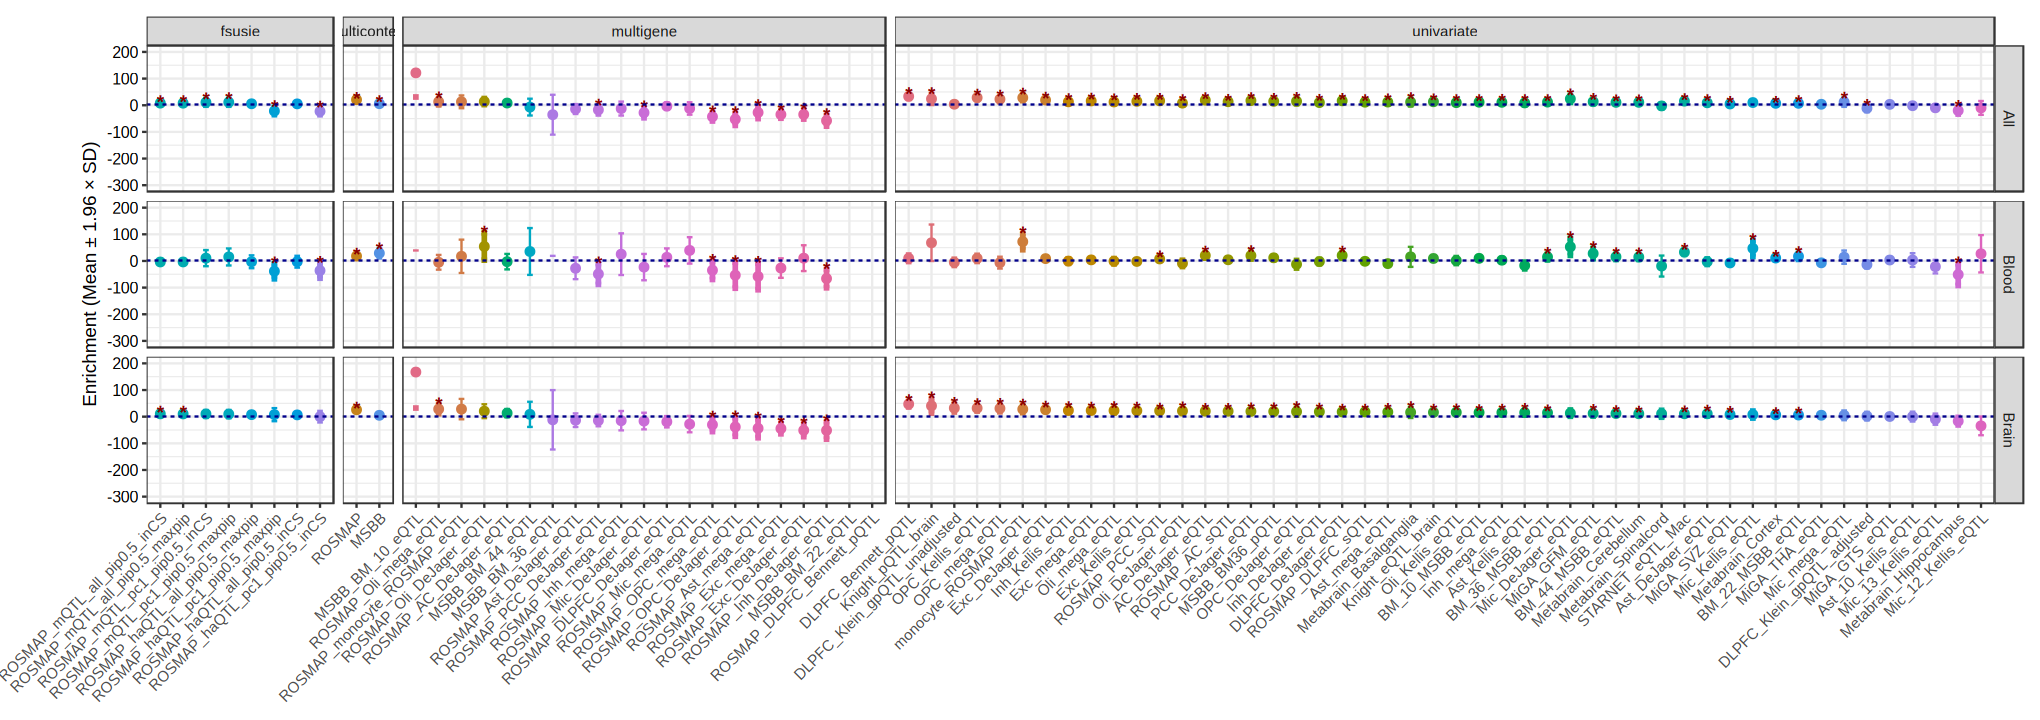

In [10]:
options(repr.plot.width = 17, repr.plot.height = 6)
reorder_levels <- enrich.df %>%
  filter(trait == "Brain") %>%          # choose reference trait
  arrange(desc(Mean)) %>%               # descending by Mean
  pull(study) %>%                       # get vector
  unique()

enrich.df$study <- factor(enrich.df$study, levels = reorder_levels)

## 5. Mark significance (95 % CI does NOT include zero) ---------
enrich.df <- enrich.df %>%
  mutate(signif = Lower * Upper > 0)

## 6. Prepare a colour palette ---------------------------------
all_colors <- qualitative_hcl(
  n = length(levels(enrich.df$study)),
  palette = "Dark 3"
)

## 7. Plot -------------------------------------------------------
p2 <- ggplot(
  enrich.df,
  aes(x = study, y = Mean,
      colour = study,          # one colour per study
      group  = method)         # required for dodging
) +
  # point estimates
  geom_point(
    position = position_dodge(width = 0.6),
    size = 2
  ) +
  # error bars (95 % CI)
  geom_errorbar(
    aes(ymin = Lower, ymax = Upper,
        linewidth = signif),               # thick if significant
    position = position_dodge(width = 0.6),
    width = 0.25
  ) +
  # asterisks on significant estimates
  geom_text(
    data = subset(enrich.df, signif),
    aes(label = "*", y = Upper + 2),
    position = position_dodge(width = 0.6),
    colour = "darkred", size = 4,fontface = "bold",
  ) +
  # colour & linewidth scales
  scale_color_manual(values = all_colors) +
  scale_linewidth_manual(values = c(`TRUE` = 1.2, `FALSE` = 0.5)) +
  # horizontal zero line
  geom_hline(yintercept = 1, linetype = 2, colour = "darkblue") +
  # facet: rows = trait, columns = method
  facet_grid(
    trait ~ method,
    scales = "free_x",   # each column keeps only its own studies
    space  = "free_x"    # and shrinks horizontally
  ) +
  # theme tweaks
  theme_bw() +
  theme(
    axis.text.x  = element_text(angle = 45, hjust = 1, vjust = 1),
    axis.text.y  = element_text(size = 9,  colour = "black"),
    axis.title.x = element_blank(),
    plot.margin = margin(t = 10, r = 10, b = 10, l = 50),
    legend.position = "none"
  ) +
  ylim(c(-300,200))+
  # axis title
  ylab("Enrichment (Mean ± 1.96 × SD)")
print(p2)
ggsave("enrichment_all.png",width = 18,height = 8)


### Barplot showing joint tau values across QTL studies

[1] TRUE

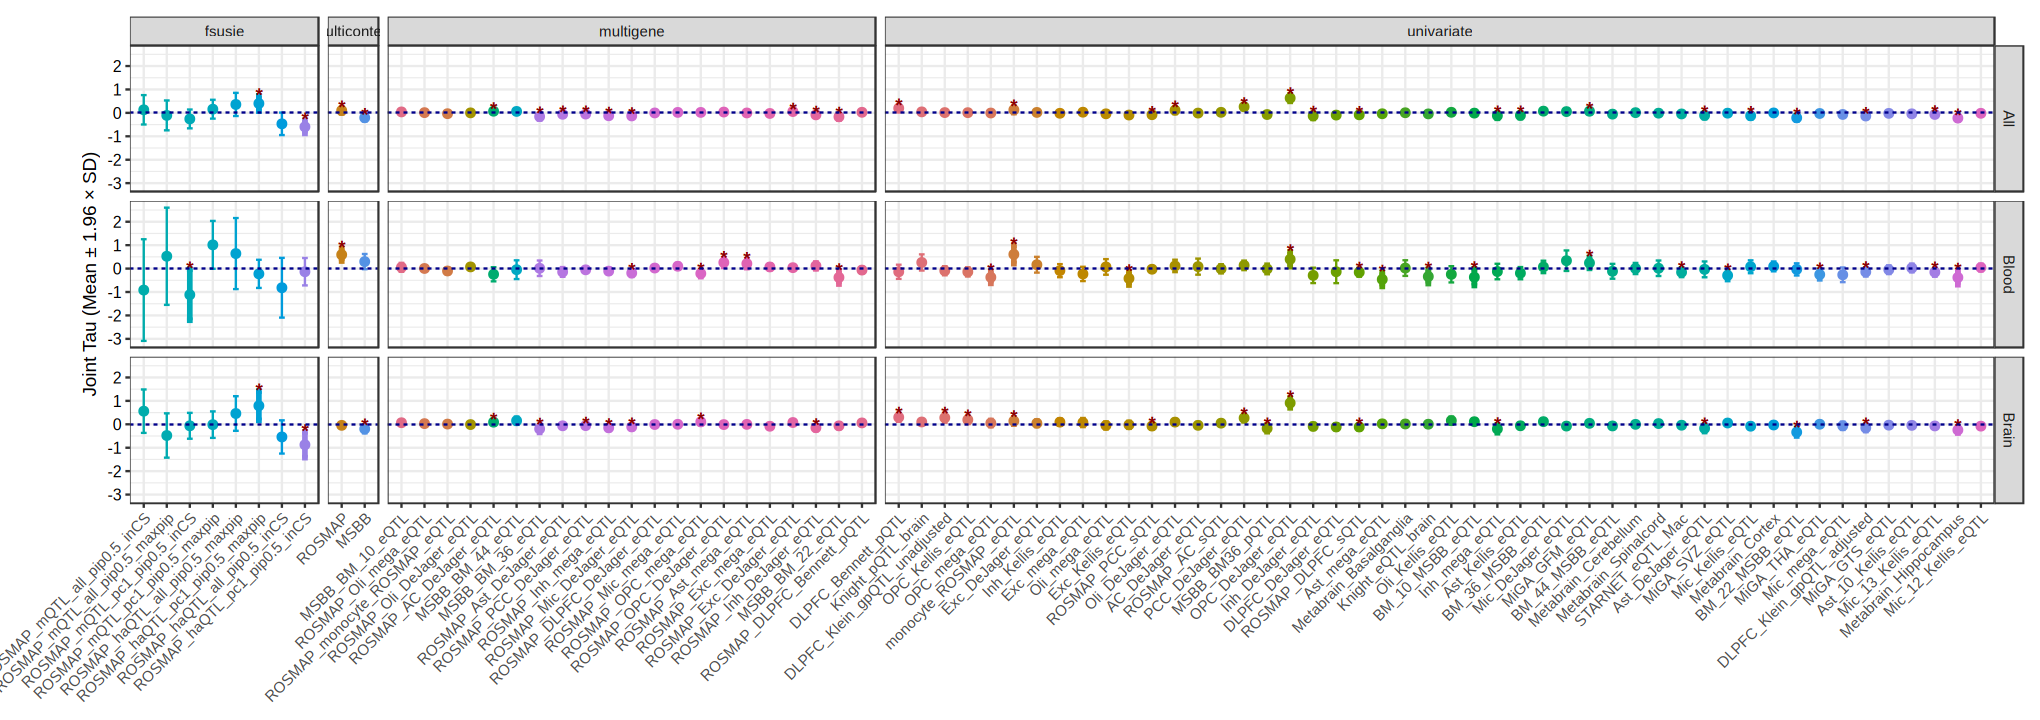

In [14]:
options(repr.plot.width = 17, repr.plot.height = 6)
jres <- readRDS("/projectnb/tcwlab/LabMember/pwang1/projects/Enrichment_EOO_GaoW/sLDSC/ADSP_1000G_analysis/output/qtl.joint_tau/sumstats/qtl.joint_tau.joint_tau.initial_processed_stats.rds")
res <- readRDS("/projectnb/tcwlab/LabMember/pwang1/projects/Enrichment_EOO_GaoW/sLDSC/ADSP_1000G_analysis/output/qtl.joint_tau/sumstats/processed_stats_2/joint_tau.qtl.joint_tau.meta_processed_stats.rds")

df.list <- list()
for (i in 1:3) {
  df <- data.frame(res[[i]])
  df$study <- studies
  df$trait <- names(res)[i]
  df.list[[i]] <- df
}

tau.df <- do.call(rbind, df.list)

loci.df <- loci.info[match(tau.df$study, loci.info$study),]
all(tau.df$study==loci.df$study)

tau.df$Lower <- tau.df$Mean - 1.96*tau.df$SD
tau.df$Upper <- tau.df$Mean + 1.96*tau.df$SD
tau.df$signif <- tau.df$P < 0.05
tau.df$method <- loci.df$method

reorder_levels <- enrich.df %>%
  filter(trait == "Brain") %>%          # choose reference trait
  arrange(desc(Mean)) %>%               # descending by Mean
  pull(study) %>%                       # get vector
  unique()

tau.df$study <- factor(tau.df$study, levels = reorder_levels)

## 5. Mark significance (95 % CI does NOT include zero) ---------
tau.df <- tau.df %>%
  mutate(signif = Lower * Upper > 0)

## 6. Prepare a colour palette ---------------------------------
all_colors <- qualitative_hcl(
  n = length(levels(tau.df$study)),
  palette = "Dark 3"
)

## 7. Plot -------------------------------------------------------
p3 <- ggplot(
  tau.df,
  aes(x = study, y = Mean,
      colour = study,          # one colour per study
      group  = method)         # required for dodging
) +
  # point estimates
  geom_point(
    position = position_dodge(width = 0.6),
    size = 2
  ) +
  # error bars (95 % CI)
  geom_errorbar(
    aes(ymin = Lower, ymax = Upper,
        linewidth = signif),               # thick if significant
    position = position_dodge(width = 0.6),
    width = 0.25
  ) +
  # asterisks on significant estimates
  geom_text(
    data = subset(tau.df, signif),
    aes(label = "*", y = Upper + 0.05),
    position = position_dodge(width = 0.6),
    colour = "darkred", size = 4,fontface = "bold"
  ) +
  # colour & linewidth scales
  scale_color_manual(values = all_colors) +
  scale_linewidth_manual(values = c(`TRUE` = 1.2, `FALSE` = 0.5)) +
  # horizontal zero line
  geom_hline(yintercept = 0, linetype = 2, colour = "darkblue") +
  # facet: rows = trait, columns = method
  facet_grid(
    trait ~ method,
    scales = "free_x",   # each column keeps only its own studies
    space  = "free_x"    # and shrinks horizontally
  ) +
  # theme tweaks
  theme_bw() +
  theme(
    axis.text.x  = element_text(angle = 45, hjust = 1, vjust = 1),
    axis.text.y  = element_text(size = 9,  colour = "black"),
    axis.title.x = element_blank(),
    plot.margin = margin(t = 10, r = 10, b = 10, l = 50),
    legend.position = "none"
  ) +
  # axis title
  ylab("Joint Tau (Mean ± 1.96 × SD)")
print(p3)
ggsave("joint_tau_all.png",width = 18,height = 8)


Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


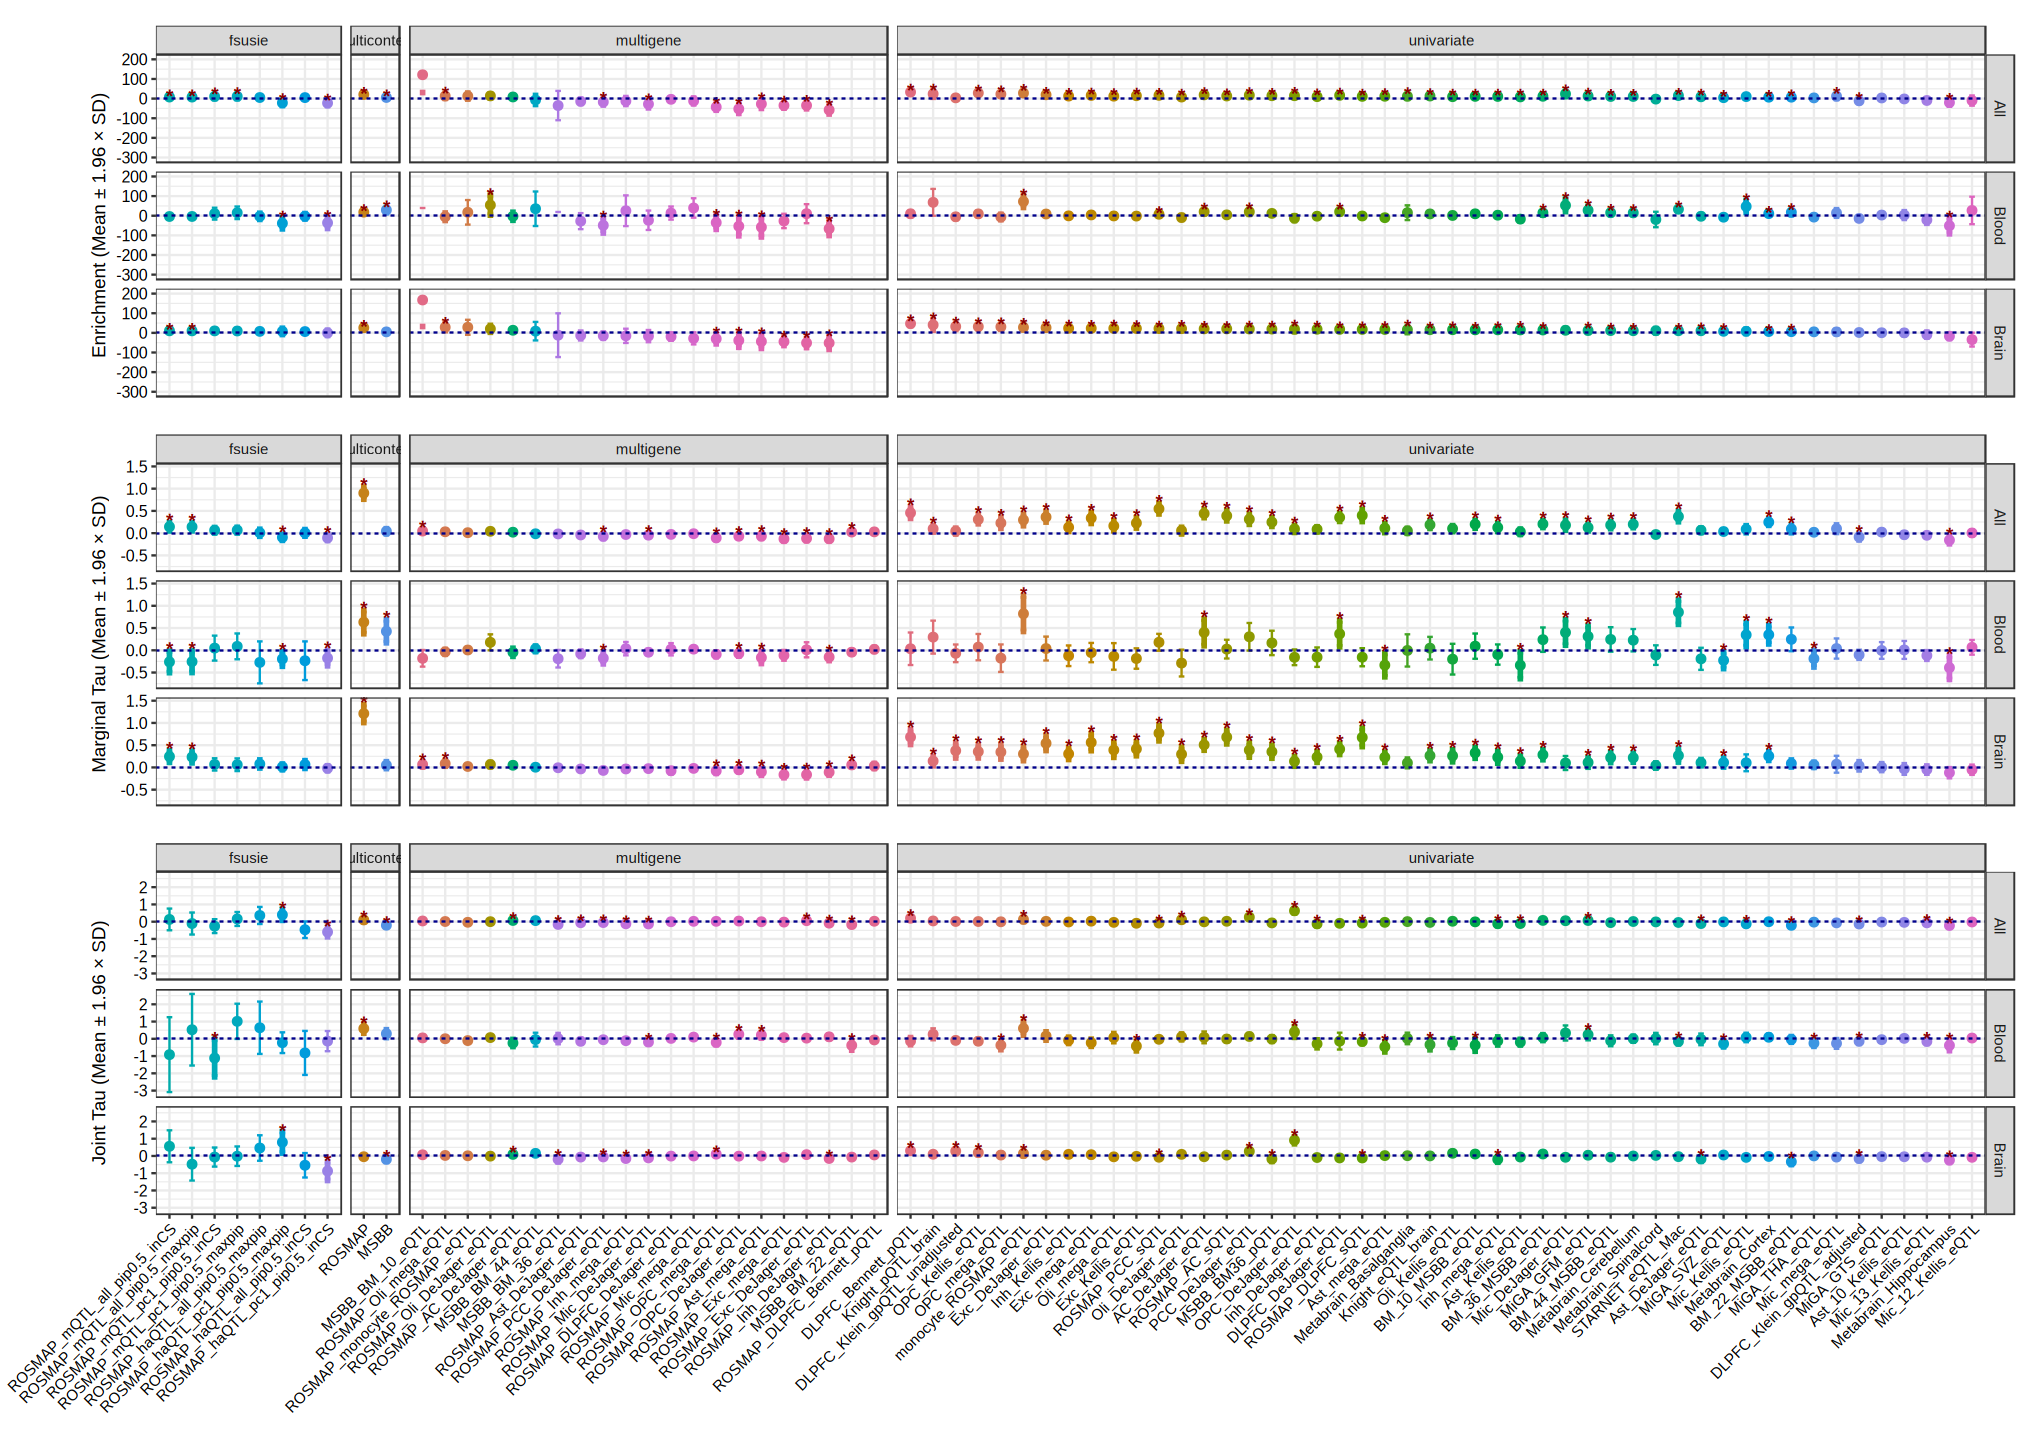

In [15]:
options(repr.plot.width = 17, repr.plot.height = 12)

library(patchwork)

(p2 + theme(axis.title.x = element_blank(),
            axis.text.x  = element_blank(),
            axis.ticks.x = element_blank())) /
(p1 + theme(axis.title.x = element_blank(),
            axis.text.x  = element_blank(),
            axis.ticks.x = element_blank())) /
(p3 + theme(axis.text = element_text(color="black")))

Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


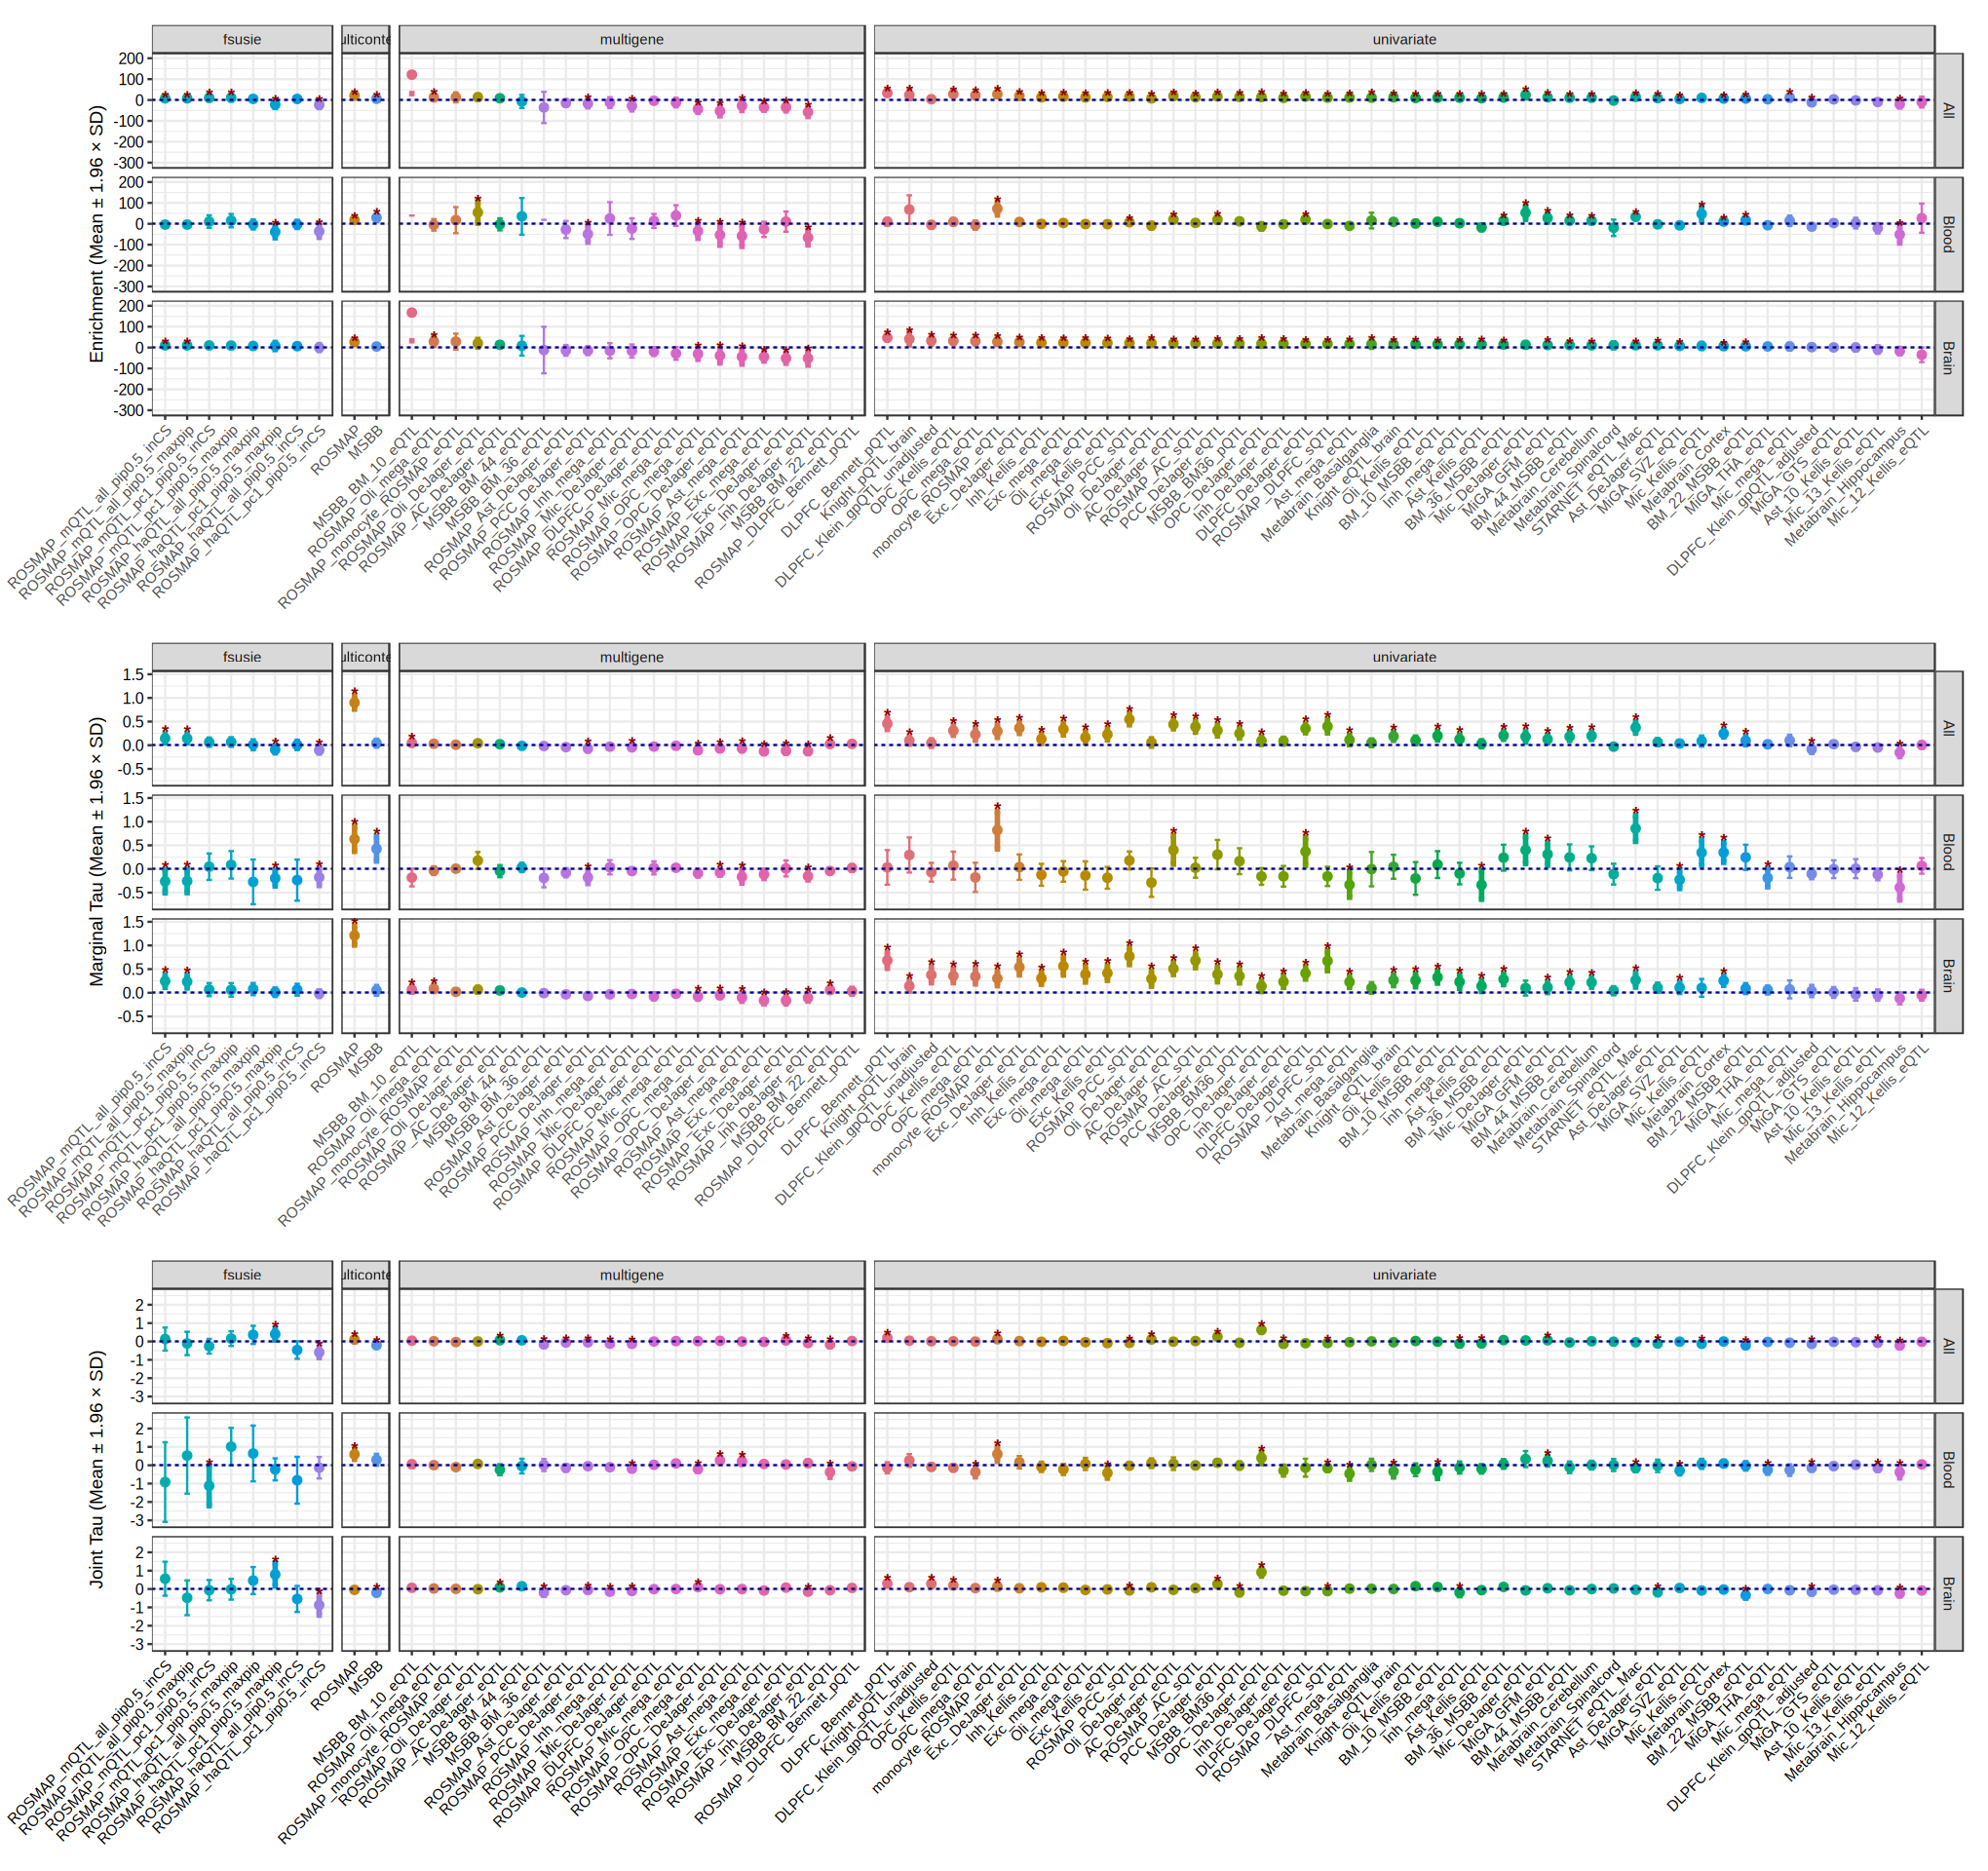

In [19]:
## Checking the consistence of xlab labels across p1,p2 and p3
options(repr.plot.width = 17, repr.plot.height = 16)

library(patchwork)

p2 /
 p1 /
 p3 + theme(axis.text = element_text(color="black"))
ggsave("marginal_joint_tau_enrichment.png",width = 16,height = 14)